<a href="https://colab.research.google.com/github/seacatgm/-/blob/main/texts/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F%20%D0%B1%D0%BE%D0%BB%D0%B5%D0%B7%D0%BD%D0%B8%20%D0%BF%D0%BE%20%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D1%8E%20%D1%81%D0%B8%D0%BC%D0%BF%D1%82%D0%BE%D0%BC%D0%BE%D0%B2/embedding%2C_symptom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive
import time


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -R '/content/symptom' # проверяем есть ли папка symptom, если есть то удаляем

rm: cannot remove '/content/symptom': No such file or directory


In [ ]:
!unzip -q '/content/drive/My Drive/neuro/base/болезни.zip' -d '/content/symptom' # загружаем базу 

In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r') # Задаем открытие нужного файла в режиме чтения
  text = f.read() # Читаем файл
  text = text.replace('\n', ' ') # Переносы строки заменяем пробелами
  return text

className = ["Язва", "Энтерит", "Эзофагит", "Холицестит", "Панкреатит", "Колит",\  # задаем названия классов для наглядности
             "Дуоденит", "Гепатит", "Гастрит", "Аппендицит"] 
nClasses = len(className) # считаем количество классов

In [ ]:
os.listdir('symptom/') # Посмотрим что содержит папка

['Аппендицит.txt',
 'Язва.txt',
 'Панкреатит.txt',
 'Холицестит.txt',
 'Эзофагит.txt',
 'Энтерит.txt',
 'Гепатит.txt',
 'Гастрит.txt',
 'Колит.txt',
 'Дуоденит.txt']

In [ ]:
def split_text(symptom): # функция прнимает текст и возвращает две выборки одна состоит из 80% текста другая 20%, обучающая и поверочная
  symptom = symptom.split() # разбиваем текст
  x = round(len(symptom)*0.8) # Берем 80% от текста
  xTrain = symptom[:x] # делаем срез от 0% до 80%
  yTrain = symptom[x:] # делаем срез от 80% до 100%

  return xTrain, yTrain 

In [ ]:
trainText = [] # Здесь будут обучающие тексты
testText = [] # Здесь будут проверочные тексты
x, y = [], [] # здесь будем хранить сплит наших выборок
for i in className: # Проходим по каждому классу
  for j in os.listdir('symptom/'): # Проходим по каждому файлу в папке с текстами
    if i in j:  # Проверяем, содержит ли файл j в названии имя класса i
      x, y = split_text(readText('symptom/' + j)) # добавляем выборки в х и у
      trainText.append(x) # добавляем обучающую выборку
      print(j, 'добавлен в обучающую выборку') 
      testText.append(y) # добавляем поверочную выборку
      print(j, 'добавлен в тестовую выборку')
  print()

Язва.txt добавлен в обучающую выборку
Язва.txt добавлен в тестовую выборку

Энтерит.txt добавлен в обучающую выборку
Энтерит.txt добавлен в тестовую выборку

Эзофагит.txt добавлен в обучающую выборку
Эзофагит.txt добавлен в тестовую выборку

Холицестит.txt добавлен в обучающую выборку
Холицестит.txt добавлен в тестовую выборку

Панкреатит.txt добавлен в обучающую выборку
Панкреатит.txt добавлен в тестовую выборку

Колит.txt добавлен в обучающую выборку
Колит.txt добавлен в тестовую выборку

Дуоденит.txt добавлен в обучающую выборку
Дуоденит.txt добавлен в тестовую выборку

Гепатит.txt добавлен в обучающую выборку
Гепатит.txt добавлен в тестовую выборку

Гастрит.txt добавлен в обучающую выборку
Гастрит.txt добавлен в тестовую выборку

Аппендицит.txt добавлен в обучающую выборку
Аппендицит.txt добавлен в тестовую выборку



In [ ]:
# Формирование обучающей выборки по листу индексов слов
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 
  while (index + xLen <= wordsLen): # Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаемся вперёд на step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step):# Функция принимает последовательность индексов, размер окна, шаг окна
  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []  # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна 
  for wI in wordIndexes: # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6

  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t]  # Берем очередной текст вида "кол-во окон в тексте*длину окна
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса
  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в сеть
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в сеть

  return (xSamples, ySamples)

In [ ]:
maxWordsCount = 5000 # задаем лимит по количеству слов, берем 20 000 самых часто встречающихся 
# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов 

xLen = 50 # задаем размер окна
step = 5 # задаем шаг

trainWordIdx = tokenizer.texts_to_sequences(trainText) # Обучающие тексты в индексы
testWordIdx = tokenizer.texts_to_sequences(testText) # Поверочные тексты в индексы

xTrain, yTrain = createSetsMultiClasses(trainWordIdx, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIdx, xLen, step) # извлекаем поверочную выборку

xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words

Epoch 1/43
16/16 [==============================] - 1s 50ms/step - loss: 2.1972 - accuracy: 0.1806 - val_loss: 2.2585 - val_accuracy: 0.2124
Epoch 2/43
16/16 [==============================] - 0s 21ms/step - loss: 1.5381 - accuracy: 0.5308 - val_loss: 2.2228 - val_accuracy: 0.1606
Epoch 3/43
16/16 [==============================] - 0s 22ms/step - loss: 0.9898 - accuracy: 0.7530 - val_loss: 2.1995 - val_accuracy: 0.1658
Epoch 4/43
16/16 [==============================] - 0s 22ms/step - loss: 0.6040 - accuracy: 0.8800 - val_loss: 2.1809 - val_accuracy: 0.1658
Epoch 5/43
16/16 [==============================] - 0s 22ms/step - loss: 0.3628 - accuracy: 0.9484 - val_loss: 2.1566 - val_accuracy: 0.1865
Epoch 6/43
16/16 [==============================] - 0s 21ms/step - loss: 0.1985 - accuracy: 0.9891 - val_loss: 2.1339 - val_accuracy: 0.2176
Epoch 7/43
16/16 [==============================] - 0s 23ms/step - loss: 0.1037 - accuracy: 0.9970 - val_loss: 2.1028 - val_accuracy: 0.2902
Epoch 8/43
16

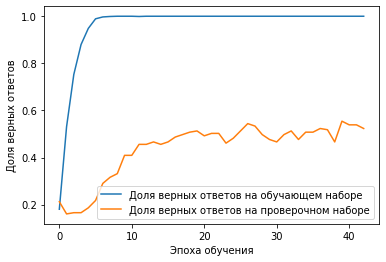

In [ ]:
# Embedding + LSTM, результат 52%

modelE = Sequential() 

modelE.add(Embedding(maxWordsCount, 10, input_length=xLen))
modelE.add(LSTM(4, return_sequences=1))
modelE.add(Dropout(0.1)) 
modelE.add(BatchNormalization()) 
modelE.add(Flatten()) 

modelE.add(Dense(10, activation='softmax')) 

modelE.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=43,
                    batch_size=64,
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/45
19/19 [==============================] - 0s 15ms/step - loss: 2.3029 - accuracy: 0.1616 - val_loss: 2.2929 - val_accuracy: 0.2174
Epoch 2/45
19/19 [==============================] - 0s 8ms/step - loss: 1.9875 - accuracy: 0.2949 - val_loss: 2.2893 - val_accuracy: 0.2043
Epoch 3/45
19/19 [==============================] - 0s 8ms/step - loss: 1.5844 - accuracy: 0.5427 - val_loss: 2.2714 - val_accuracy: 0.2043
Epoch 4/45
19/19 [==============================] - 0s 8ms/step - loss: 1.0294 - accuracy: 0.7862 - val_loss: 2.2549 - val_accuracy: 0.2000
Epoch 5/45
19/19 [==============================] - 0s 8ms/step - loss: 0.5643 - accuracy: 0.9279 - val_loss: 2.2302 - val_accuracy: 0.2304
Epoch 6/45
19/19 [==============================] - 0s 9ms/step - loss: 0.2960 - accuracy: 0.9727 - val_loss: 2.1970 - val_accuracy: 0.2478
Epoch 7/45
19/19 [==============================] - 0s 8ms/step - loss: 0.1651 - accuracy: 0.9851 - val_loss: 2.1831 - val_accuracy: 0.2870
Epoch 8/45
19/19 [=

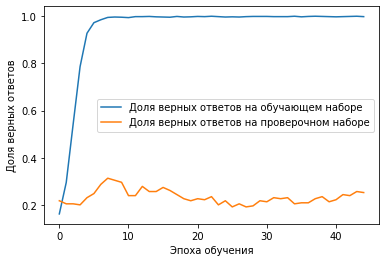

In [ ]:
# Embedding + Conv1D, результат 25%
modelE = Sequential() 

modelE.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelE.add(SpatialDropout1D(0.2))
modelE.add(BatchNormalization()) 
modelE.add(Conv1D(20, 3, activation="relu"))  
modelE.add(Dropout(0.1))  
modelE.add(Flatten()) 
modelE.add(Dense(10, activation='softmax')) 

modelE.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=45,
                    batch_size=64,
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/35
19/19 [==============================] - 1s 63ms/step - loss: 1.8700 - accuracy: 0.3463 - val_loss: 2.2617 - val_accuracy: 0.2130
Epoch 2/35
19/19 [==============================] - 1s 35ms/step - loss: 0.6729 - accuracy: 0.7606 - val_loss: 2.2660 - val_accuracy: 0.2130
Epoch 3/35
19/19 [==============================] - 1s 35ms/step - loss: 0.2700 - accuracy: 0.9105 - val_loss: 2.2784 - val_accuracy: 0.0783
Epoch 4/35
19/19 [==============================] - 1s 35ms/step - loss: 0.1685 - accuracy: 0.9412 - val_loss: 2.2740 - val_accuracy: 0.2130
Epoch 5/35
19/19 [==============================] - 1s 34ms/step - loss: 0.1313 - accuracy: 0.9660 - val_loss: 2.2632 - val_accuracy: 0.2130
Epoch 6/35
19/19 [==============================] - 1s 36ms/step - loss: 0.1194 - accuracy: 0.9660 - val_loss: 2.2739 - val_accuracy: 0.2478
Epoch 7/35
19/19 [==============================] - 1s 35ms/step - loss: 0.1113 - accuracy: 0.9594 - val_loss: 2.2549 - val_accuracy: 0.2130
Epoch 8/35
19

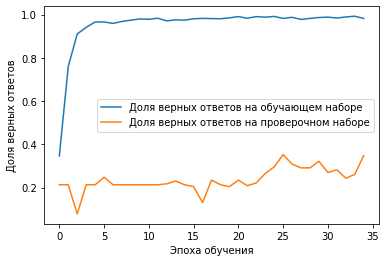

In [ ]:
# Embedding + Dense, LSTM и Conv1D, результат 34%
modelE = Sequential() 

modelE.add(Embedding(maxWordsCount, 10, input_length=xLen))


modelE.add(SpatialDropout1D(0.2))
modelE.add(BatchNormalization()) 
modelE.add(LSTM(6, return_sequences=1))

modelE.add(Conv1D(5, 1, activation="relu")) 
modelE.add(MaxPooling1D(2)) 
modelE.add(Dropout(0.2)) 

modelE.add(Dense(250, activation='relu'))
modelE.add(BatchNormalization()) 
modelE.add(Flatten()) 

modelE.add(Dense(10, activation='softmax')) 

modelE.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=35,
                    batch_size=64,
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
modelE.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_69 (Embedding)     (None, 50, 10)            200000    
_________________________________________________________________
spatial_dropout1d_68 (Spatia (None, 50, 10)            0         
_________________________________________________________________
batch_normalization_105 (Bat (None, 50, 10)            40        
_________________________________________________________________
lstm_40 (LSTM)               (None, 50, 5)             320       
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 50, 5)             30        
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 25, 5)             0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 25, 5)           